# Federated Learning

Resource: https://www.deeplearning.ai/short-courses/intro-to-federated-learning/

## Helper functions

In [4]:
from collections import OrderedDict
import logging
from logging import INFO
import warnings

from flwr.common import ndarrays_to_parameters, Context
from flwr.server import ServerAppComponents
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common.logger import (
    ConsoleHandler,
    console_handler,
    FLOWER_LOGGER,
    LOG_COLORS,
)
from logging import LogRecord
from flwr.server import ServerApp, ServerConfig
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, Normalize, ToTensor


# Customize logging for the course.
class InfoFilter(logging.Filter):
    def filter(self, record):
        return record.levelno == INFO


FLOWER_LOGGER.removeHandler(console_handler)
warnings.filterwarnings("ignore")

# To filter logging coming from the Simulation Engine
# so it's more readable in notebooks
from logging import ERROR
backend_setup = {"init_args": {"logging_level": ERROR, "log_to_driver": True}}

class ConsoleHandlerV2(ConsoleHandler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def format(self, record: LogRecord) -> str:
        """Format function that adds colors to log level."""
        if self.json:
            log_fmt = "{lvl='%(levelname)s', time='%(asctime)s', msg='%(message)s'}"
        else:
            log_fmt = (
                f"{LOG_COLORS[record.levelname] if self.colored else ''}"
                f"%(levelname)s {'%(asctime)s' if self.timestamps else ''}"
                f"{LOG_COLORS['RESET'] if self.colored else ''}"
                f": %(message)s"
            )
        formatter = logging.Formatter(log_fmt)
        return formatter.format(record)


console_handlerv2 = ConsoleHandlerV2(
    timestamps=False,
    json=False,
    colored=True,
)
console_handlerv2.setLevel(INFO)
console_handlerv2.addFilter(InfoFilter())
FLOWER_LOGGER.addHandler(console_handlerv2)

## Why federated learning

In [5]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
])

trainset = datasets.MNIST(
    root="../data/",
    download=True,
    train=True,
    transform=transform,
    target_transform=None,
)

100%|██████████| 9.91M/9.91M [00:08<00:00, 1.22MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 278kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 595kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.2MB/s]


In [6]:
# Split data into three parts
import torch
from torch.utils.data import random_split

total_length= len(trainset)
split_size = total_length // 3
torch.manual_seed(42)

part_1, part_2, part_3 = random_split(trainset, [split_size] * 3)

In [7]:
# Delete specific digits from training sets
from torch.utils.data import Subset

def exclude_digits(dataset, exclude_digits):
    including_indices = [
        idx for idx in range(len(dataset)) if dataset[idx][1] not in exclude_digits
    ]
    
    return Subset(dataset, indices=including_indices)

part_1 = exclude_digits(part_1, exclude_digits=[1, 3, 7])
part_2 = exclude_digits(part_2, exclude_digits=[2, 5, 8])
part_3 = exclude_digits(part_3, exclude_digits=[4, 6 ,9])

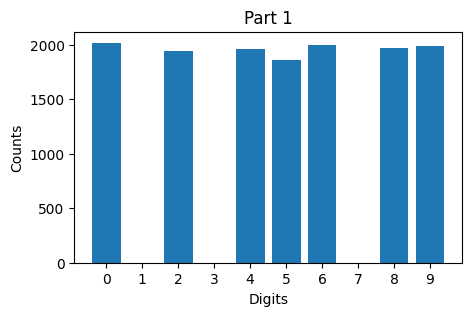

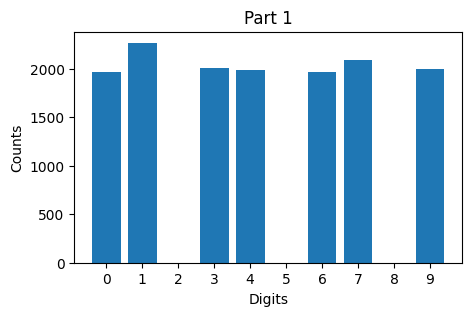

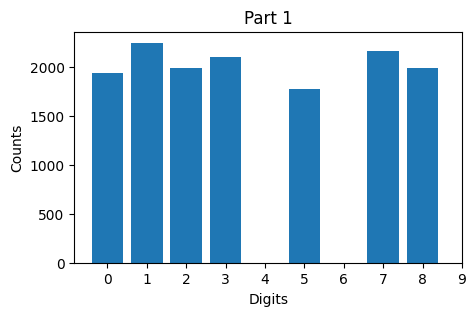

In [8]:
# Visualize distributions
import numpy as np
import matplotlib.pyplot as plt

def plot_distribution(dataset, title):
    labels = [data[1] for data in dataset]
    unique_labels, label_counts = torch.unique(torch.tensor(labels), return_counts=True)
        
    plt.figure(figsize=(5, 3))
    plt.bar(x=unique_labels, height=label_counts)
    plt.title(title)
    plt.xlabel("Digits")
    plt.ylabel("Counts")
    plt.xticks(np.arange(10))
    plt.show()

plot_distribution(part_1, "Part 1")
plot_distribution(part_2, "Part 1")
plot_distribution(part_3, "Part 1")

In [9]:
# Train models
import torch.nn as nn
from torch.utils.data import DataLoader

class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(128, 10)
    
    def forward(self, x):
        return self.linear_2(
            self.relu(
                self.linear_1(
                    self.flatten(x)
                )
            )
        )

def train_model(model, train_set):
    BATCH_SIZE = 32
    NUM_EPOCHS = 5
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        params=model.parameters(),
        lr = 0.01,
    )
    
    loader = DataLoader(
        dataset=train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
    
    model.train()
    
    for epoch in range(NUM_EPOCHS):
        total_loss = 0
        
        for X, y in loader:
            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
    
        print(f"Epoch: {epoch} | Loss: {total_loss / len(loader)}")
    
    print("Trainig completed...\n")

In [10]:
model_1 = Model()
train_model(model_1, part_1)

model_2 = Model()
train_model(model_2, part_1)

model_3 = Model()
train_model(model_3, part_1)

Epoch: 0 | Loss: 1.3955728754054668
Epoch: 1 | Loss: 0.5616558993971625
Epoch: 2 | Loss: 0.39006809291408157
Epoch: 3 | Loss: 0.32872846190666044
Epoch: 4 | Loss: 0.29573934064355006
Trainig completed...

Epoch: 0 | Loss: 1.4490871339343314
Epoch: 1 | Loss: 0.5722171763001487
Epoch: 2 | Loss: 0.39605232744022856
Epoch: 3 | Loss: 0.33597905434841335
Epoch: 4 | Loss: 0.30107304362017057
Trainig completed...

Epoch: 0 | Loss: 1.4175367148809654
Epoch: 1 | Loss: 0.555750678583633
Epoch: 2 | Loss: 0.3897400065216907
Epoch: 3 | Loss: 0.32621989243685506
Epoch: 4 | Loss: 0.2954864794778269
Trainig completed...



In [11]:
# Download MNIST test dataset
from torchvision import datasets, transforms

testset = datasets.MNIST(
    root="../data/",
    download=True,
    train=False,
    transform=transform,
    target_transform=None,
)

In [12]:
def include_digits(dataset, included_digits):
    including_indices = [
        idx for idx in range(len(dataset)) if dataset[idx][1] in included_digits
    ]
    return torch.utils.data.Subset(dataset, including_indices)

testset_137 = include_digits(testset, included_digits=[1, 3, 7])
testset_258 = include_digits(testset, included_digits=[2, 5, 8])
testset_469 = include_digits(testset, included_digits=[4, 6, 9])

In [13]:
# Evaluate models
def evaluate_model(model, test_set):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    loader = DataLoader(test_set, batch_size=64, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for X, y in loader:
            y_pred = model(X)
            
            _, predicted = torch.max(y_pred.data, 1)
            
            total += y.size(0)
            
            correct += (predicted == y).sum().item()

            loss = loss_fn(y_pred, y)
            
            total_loss += loss.item()

    accuracy = correct / total
    average_loss = total_loss / len(loader)

    return average_loss, accuracy

In [14]:
_, accuracy1 = evaluate_model(model_1, testset)
_, accuracy1_on_137 = evaluate_model(model_1, testset_137)
print(
    f"Model 1:\nTest Accuracy on all digits: {accuracy1:.4f}, "
    f"Test Accuracy on [1,3,7]: {accuracy1_on_137:.4f}\n"
)

_, accuracy2 = evaluate_model(model_2, testset)
_, accuracy2_on_258 = evaluate_model(model_2, testset_258)
print(
    f"Model 2:\nTest Accuracy on all digits: {accuracy2:.4f}, "
    f"Test Accuracy on [2,5,8]: {accuracy2_on_258:.4f}\n"
)

_, accuracy3 = evaluate_model(model_3, testset)
_, accuracy3_on_469 = evaluate_model(model_3, testset_469)
print(
    f"Model 3:\nTest Accuracy on all digits: {accuracy3:.4f}, "
    f"Test Accuracy on [4,6,9]: {accuracy3_on_469:.4f}\n"
)

Model 1:
Test Accuracy on all digits: 0.6239, Test Accuracy on [1,3,7]: 0.0000

Model 2:
Test Accuracy on all digits: 0.6202, Test Accuracy on [2,5,8]: 0.8799

Model 3:
Test Accuracy on all digits: 0.6209, Test Accuracy on [4,6,9]: 0.9223



In [15]:
# Create confusion matrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, testset, title):
    y_true = []
    y_pred = []

    for X, y in testset:
        logit = model(X.unsqueeze(0))  # Add batch dimension
        _, pred = torch.max(logit, 1)

        y_true.append(y)
        y_pred.append(pred.item())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", linewidths=0.5)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

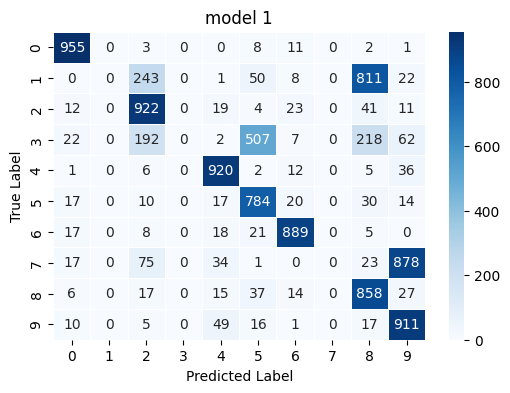

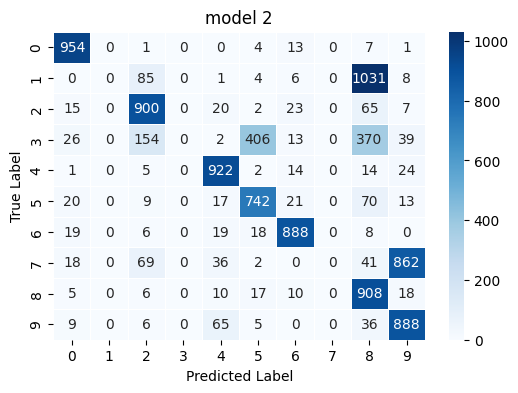

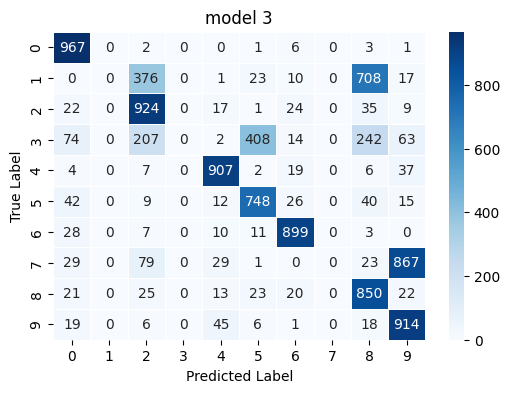

In [16]:
plot_confusion_matrix(model_1, testset, "model 1")
plot_confusion_matrix(model_2, testset, "model 2")
plot_confusion_matrix(model_3, testset, "model 3")

## Federated learning process

In [17]:
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import ndarrays_to_parameters, Context
from flwr.server import ServerApp, ServerConfig
from flwr.server import ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

In [18]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [19]:
trainset = datasets.MNIST(
    "../data/MNIST_data/",
    download=True,
    train=True,
    transform=transform
)

100%|██████████| 9.91M/9.91M [00:06<00:00, 1.55MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 142kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 774kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 21.3MB/s]


In [20]:
total_length = len(trainset)
split_size = total_length // 3

In [21]:
torch.manual_seed(42)
part_1, part_2, part_3 = random_split(trainset, [split_size] * 3)

In [22]:
part_1 = exclude_digits(part_1, exclude_digits=[1, 3, 7])
part_2 = exclude_digits(part_2, exclude_digits=[2, 5, 8])
part_3 = exclude_digits(part_3, exclude_digits=[3, 6, 9])

train_sets = [part_1, part_2, part_3]

In [23]:
testset = datasets.MNIST(
    "../data/MNIST_data", 
    download=True,
    train=False,
    transform=transform,
)

print(f"Number of examples in `testset`: {len(testset)}")

Number of examples in `testset`: 10000


In [24]:
test_set_137 = include_digits(testset, [1, 3, 7])
test_set_258 = include_digits(testset, [2, 4, 8])
test_set_369 = include_digits(testset, [3, 5, 9])

### Create training and testing pipeline

In [25]:
# Set parameters of model
from typing import OrderedDict

def set_weights(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict(
        {k: torch.tensor(v) for k, v in params_dict}
    )
    net.load_state_dict(state_dict, strict=True)

# Retrieve parameters of the model
def get_weights(net):
    ndarrays = [
        val.cpu().numpy() for _, val in net.state_dict().items()
    ]
    return ndarrays

In [26]:
from typing import Dict
from flwr.common import NDArrays, Scalar

# Connect the training in the pipeline using the Flower Client
class FlowerClient(NumPyClient):
    def __init__(self, net, trainset, testset):
        self.net = net
        self.trainset = trainset
        self.testset = testset
    
    def fit(self, parameters, config):
        set_weights(self.net, parameters)
        train_model(self.net, self.trainset)
        return get_weights(self.net), len(self.trainset), {}
    
    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        set_weights(self.net, parameters)
        loss, accuracy = evaluate_model(self.net, self.testset)
        return loss, len(self.testset), {"accuracy": accuracy}

In [27]:
# Flower calls client_fn whenever it needs an instance of one particular client to call fit or evaluate
def client_fn(context: Context) -> Client:
    net = Model()
    partition_id = int(context.node_config["partition-id"])
    client_train = train_sets[int(partition_id)]
    client_test = testset
    return FlowerClient(net, client_train, client_test).to_client()

In [28]:
# Create an instance of the ClientApp
client = ClientApp(client_fn)

In [29]:
#Define evaluate for testing
def evaluate(server_round, parameters, config):
    net = Model()
    set_weights(net, parameters)
    
    _, accuracy = evaluate_model(net, testset)
    _, accuracy_137 = evaluate_model(net, testset_137)
    _, accuracy_258 = evaluate_model(net, testset_258)
    _, accuracy_469 = evaluate_model(net, testset_469)
    
    print(f"Test accuracy on all digits: {accuracy:.4f}")
    print(f"Test accuracy on [1, 3, 7]: {accuracy_137:.4f}")
    print(f"Test accuracy on [2, 5, 8]: {accuracy_258:.4f}")
    print(f"Test accuracy on [4, 6, 9]: {accuracy_469:.4f}")
    
    if server_round == 3:
        plot_confusion_matrix(
            model=net,
            testset=testset,
            title="Final Global Midek"
        )

In [30]:
# Federated Average 'FedAvg' strategy
net = Model()
params = ndarrays_to_parameters(get_weights(net))

def server_fn(context: Context):
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.0,
        initial_parameters=params,
        evaluate_fn=evaluate,
    )
    config = ServerConfig(num_rounds=3)
    
    return ServerAppComponents(
        strategy=strategy,
        config=config
    )

In [31]:
# Create an instance of ServerApp
server = ServerApp(server_fn=server_fn)

INFO : Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO : 
INFO : [INIT]
INFO : Using initial global parameters provided by strategy
INFO : Starting evaluation of initial global parameters
INFO : Evaluation returned no results (`None`)
INFO : 
INFO : [ROUND 1]
INFO : configure_fit: strategy sampled 3 clients (out of 3)


Test accuracy on all digits: 0.1267
Test accuracy on [1, 3, 7]: 0.1510
Test accuracy on [2, 5, 8]: 0.0783
Test accuracy on [4, 6, 9]: 0.0051
(ClientAppActor pid=81715) Epoch: 0 | Loss: 0.821922370098358
(ClientAppActor pid=81715) Trainig completed...
(ClientAppActor pid=81715) 


INFO : aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=81714) 
(ClientAppActor pid=81713) 


INFO : configure_evaluate: no clients selected, skipping evaluation
INFO : 
INFO : [ROUND 2]
INFO : configure_fit: strategy sampled 3 clients (out of 3)


Test accuracy on all digits: 0.6363
Test accuracy on [1, 3, 7]: 0.4444
Test accuracy on [2, 5, 8]: 0.6698
Test accuracy on [4, 6, 9]: 0.6819
(ClientAppActor pid=81715) Epoch: 0 | Loss: 0.26394321810394455 [repeated 15x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=81713) Trainig completed... [repeated 2x across cluster]


INFO : aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=81715) 
(ClientAppActor pid=81713) 
(ClientAppActor pid=81714) 


INFO : configure_evaluate: no clients selected, skipping evaluation
INFO : 
INFO : [ROUND 3]
INFO : configure_fit: strategy sampled 3 clients (out of 3)


Test accuracy on all digits: 0.7787
Test accuracy on [1, 3, 7]: 0.5638
Test accuracy on [2, 5, 8]: 0.8233
Test accuracy on [4, 6, 9]: 0.8545
(ClientAppActor pid=81715) Epoch: 0 | Loss: 0.18363521398113877 [repeated 15x across cluster]
(ClientAppActor pid=81714) Trainig completed... [repeated 3x across cluster]
(ClientAppActor pid=81714) 


INFO : aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=81715) 
(ClientAppActor pid=81713) 
Test accuracy on all digits: 0.8129
Test accuracy on [1, 3, 7]: 0.6899
Test accuracy on [2, 5, 8]: 0.8885
Test accuracy on [4, 6, 9]: 0.8901


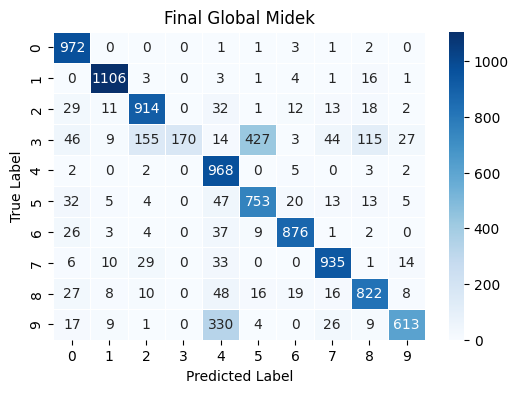

INFO : configure_evaluate: no clients selected, skipping evaluation
INFO : 
INFO : [SUMMARY]
INFO : Run finished 3 round(s) in 28.90s
INFO : 


(ClientAppActor pid=81713) Epoch: 4 | Loss: 0.15527464483930672 [repeated 14x across cluster]
(ClientAppActor pid=81713) Trainig completed... [repeated 3x across cluster]


In [32]:
# Start training 
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=3,
)

## Tuning

In [33]:
from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor

In [35]:
DEVICE = torch.device("cpu")
transforms = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

def normalize(batch):
    batch["image"] = [transforms(img) for img in batch["image"]]
    return batch


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.relu(x)
        x = self.out(x)
        return x


def train_model(net, trainloader, epochs: int = 1):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()

    for _ in range(epochs):
        for batch in trainloader:
            images = batch["image"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()


def evaluate_model(net, testloader):
    net.to(DEVICE)
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    with torch.no_grad():
        for batch in testloader:
            images = batch["image"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            outputs = net(images.to(DEVICE))
            labels = labels.to(DEVICE)
            loss += criterion(outputs, labels).item()
            correct += (
                (torch.max(outputs.data, 1)[1] == labels).sum().item()
            )
    accuracy = correct / len(testloader.dataset)
    return float(loss), float(accuracy)

In [36]:
def load_data(partition_id):
    fds = FederatedDataset(dataset="mnist", partitioners={"train": 5})
    partition = fds.load_partition(partition_id)

    traintest = partition.train_test_split(test_size=0.2, seed=42)
    traintest = traintest.with_transform(normalize)
    trainset, testset = traintest["train"], traintest["test"]

    trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
    testloader = DataLoader(testset, batch_size=64)
    
    return trainloader, testloader

### Clients configuration

In [37]:
def fit_config(server_round: int):
    config_dict = {
        "local_epochs": 2 if server_round < 3 else 5,
    }
    return config_dict

In [38]:
net = Model()
params = ndarrays_to_parameters(get_weights(net))

# FedAvg strategy in the Server Function
def server_fn(context: Context):
    strategy = FedAvg(
        min_fit_clients=5,
        fraction_evaluate=0.0,
        initial_parameters=params,
        on_fit_config_fn=fit_config,
    )
    config=ServerConfig(num_rounds=3)
    return ServerAppComponents(
        strategy=strategy,
        config=config,
    )

In [39]:
# Define an instance of ServerApp
server = ServerApp(server_fn=server_fn)

In [40]:
# Define FlowerClient
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, testloader):
        self.net = net
        self.trainloader = trainloader
        self.testloader = testloader

    def fit(self, parameters, config):
        set_weights(self.net, parameters)

        epochs = config["local_epochs"]
        log(INFO, f"client trains for {epochs} epochs")
        train_model(self.net, self.trainloader, epochs)

        return get_weights(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_weights(self.net, parameters)
        loss, accuracy = evaluate_model(self.net, self.testloader)
        return loss, len(self.testloader), {"accuracy": accuracy}

In [41]:
# Create the Client Function and the Client App
def client_fn(context: Context) -> Client:
    net = Model()
    partition_id = int(context.node_config["partition-id"])
    trainloader, testloader = load_data(partition_id=partition_id)
    return FlowerClient(net, trainloader, testloader).to_client()


client = ClientApp(client_fn)

In [42]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=5,
    backend_config=backend_setup
)

INFO : Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO : 
INFO : [INIT]
INFO : Using initial global parameters provided by strategy
INFO : Starting evaluation of initial global parameters
INFO : Evaluation returned no results (`None`)
INFO : 
INFO : [ROUND 1]
INFO : configure_fit: strategy sampled 5 clients (out of 5)
Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 704451.46 examples/s]
INFO : aggregate_fit: received 0 results and 5 failures
INFO : configure_evaluate: no clients selected, skipping evaluation
INFO : 
INFO : [ROUND 2]
INFO : configure_fit: strategy sampled 5 clients (out of 5)
INFO : aggregate_fit: received 0 results and 5 failures
INFO : configure_evaluate: no clients selected, skipping evaluation
INFO : 
INFO : [ROUND 3]
INFO : configure_fit: strategy sampled 5 clients (out of 5)
INFO : aggregate_fit: received 0 results and 5 failures
INFO : configure_evaluate: no clients selected, skipping evaluation
INFO : 
INFO : [SUMMARY]
IN

## Data privay

In [44]:
from flwr.client.mod import adaptiveclipping_mod
from flwr.server.strategy import (
    DifferentialPrivacyClientSideAdaptiveClipping,
    FedAvg,
)

In [45]:
# Load MINST dataset
def load_data(partition_id):
    fds = FederatedDataset(dataset="mnist", partitioners={"train": 10})
    partition = fds.load_partition(partition_id)

    traintest = partition.train_test_split(test_size=0.2, seed=42)
    traintest = traintest.with_transform(normalize)
    trainset, testset = traintest["train"], traintest["test"]

    trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
    testloader = DataLoader(testset, batch_size=64)
    return trainloader, testloader

In [46]:
# Define model and client
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, testloader):
        self.net = net
        self.trainloader = trainloader
        self.testloader = testloader

    def fit(self, parameters, config):
        set_weights(self.net, parameters)
        train_model(self.net, self.trainloader)
        return get_weights(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_weights(self.net, parameters)
        loss, accuracy = evaluate_model(self.net, self.testloader)
        return loss, len(self.testloader), {"accuracy": accuracy}


def client_fn(context: Context) -> Client:
    net = SimpleModel()
    partition_id = int(context.node_config["partition-id"])
    trainloader, testloader = load_data(partition_id=partition_id)
    return FlowerClient(net, trainloader, testloader).to_client()

In [47]:
# Define client app
client = ClientApp(
    client_fn,
    mods=[adaptiveclipping_mod],  # modifiers
)

In [48]:
# Define server with strategy
net = Model()
params = ndarrays_to_parameters(get_weights(net))

def server_fn(context: Context):
    fedavg_without_dp = FedAvg(
        fraction_fit=0.6,
        fraction_evaluate=1.0,
        initial_parameters=params,
    )
    fedavg_with_dp = DifferentialPrivacyClientSideAdaptiveClipping(
        fedavg_without_dp,
        noise_multiplier=0.3,
        num_sampled_clients=6,
    )
    
    # Adjust to 50 rounds to ensure DP guarantees hold
    # with respect to the desired privacy budget
    config = ServerConfig(num_rounds=5)
    
    return ServerAppComponents(
        strategy=fedavg_with_dp,
        config=config,
    )

In [49]:
server = ServerApp(server_fn=server_fn)

In [50]:
# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=10,
    backend_config=backend_setup
)

INFO : Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO : 
INFO : [INIT]
INFO : Using initial global parameters provided by strategy
INFO : Starting evaluation of initial global parameters
INFO : Evaluation returned no results (`None`)
INFO : 
INFO : [ROUND 1]
INFO : configure_fit: strategy sampled 6 clients (out of 10)
INFO : aggregate_fit: received 0 results and 6 failures
INFO : configure_evaluate: strategy sampled 10 clients (out of 10)
INFO : aggregate_evaluate: received 0 results and 10 failures
INFO : 
INFO : [ROUND 2]
INFO : configure_fit: strategy sampled 6 clients (out of 10)
INFO : aggregate_fit: received 0 results and 6 failures
INFO : configure_evaluate: strategy sampled 10 clients (out of 10)
INFO : aggregate_evaluate: received 0 results and 10 failures
INFO : 
INFO : [ROUND 3]
INFO : configure_fit: strategy sampled 6 clients (out of 10)
INFO : aggregate_fit: received 0 results and 6 failures
INFO : configure_evaluate: strategy sampled 10 clients (ou

## Bandwidth

In [53]:
from flwr.client.mod import message_size_mod

In [54]:
from transformers import AutoModelForCausalLM, GPTNeoXForCausalLM

# Initialize model
model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/pythia-14m",
    cache_dir="../models/pythia-14m/cache",
)

In [57]:
# Get some model values
vals = model.state_dict().values()
total_size_bytes = sum(p.element_size() * p.numel() for p in vals)
total_size_mb = int(total_size_bytes / (1024**2))

print("Model size is: {} MB".format(total_size_mb))

Model size is: 53 MB


In [58]:
# Define Flower Client
class FlowerClient(NumPyClient):
    def __init__(self, net):
        self.net = net

    def fit(self, parameters, config):
        set_weights(self.net, parameters)
        # No actual training here
        return get_weights(self.net), 1, {}

    def evaluate(self, parameters, config):
        set_weights(self.net, parameters)
        # No actual evaluation here
        return float(0), int(1), {"accuracy": 0}


def client_fn(context: Context) -> FlowerClient:
    return FlowerClient(model).to_client()


client = ClientApp(
    client_fn,
    mods=[message_size_mod],
)

In [59]:
# Define the custom strategy: BandwidthTrackingFedAvg
bandwidth_sizes = []

class BandwidthTrackingFedAvg(FedAvg):
    def aggregate_fit(self, server_round, results, failures):
        if not results:
            return None, {}

        # Track sizes of models received
        for _, res in results:
            ndas = parameters_to_ndarrays(res.parameters)
            size = int(sum(n.nbytes for n in ndas) / (1024**2))
            log(INFO, f"Server receiving model size: {size} MB")
            bandwidth_sizes.append(size)

        # Call FedAvg for actual aggregation
        return super().aggregate_fit(server_round, results, failures)

    def configure_fit(self, server_round, parameters, client_manager):
        # Call FedAvg for actual configuration
        instructions = super().configure_fit(
            server_round, parameters, client_manager
        )

        # Track sizes of models to be sent
        for _, ins in instructions:
            ndas = parameters_to_ndarrays(ins.parameters)
            size = int(sum(n.nbytes for n in ndas) / (1024**2))
            log(INFO, f"Server sending model size: {size} MB")
            bandwidth_sizes.append(size)

        return instructions

In [60]:
params = ndarrays_to_parameters(get_weights(model))

def server_fn(context: Context):
    strategy = BandwidthTrackingFedAvg(
        fraction_evaluate=0.0,
        initial_parameters=params,
    )
    config = ServerConfig(num_rounds=1)
    return ServerAppComponents(
        strategy=strategy,
        config=config,
    )


server = ServerApp(server_fn=server_fn)

In [61]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=2,
    backend_config=backend_setup
)

INFO : Starting Flower ServerApp, config: num_rounds=1, no round_timeout
INFO : 
INFO : [INIT]
INFO : Using initial global parameters provided by strategy
INFO : Starting evaluation of initial global parameters
INFO : Evaluation returned no results (`None`)
INFO : 
INFO : [ROUND 1]
Exception in thread Thread-30 (server_th_with_start_checks):
Traceback (most recent call last):
  File "/home/michal-chojna/.local/share/uv/python/cpython-3.10.18-linux-x86_64-gnu/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/michal-chojna/Desktop/Repos/llm-playground/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "/home/michal-chojna/.local/share/uv/python/cpython-3.10.18-linux-x86_64-gnu/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/michal-chojna/Desktop/Repos/llm-playground/.venv/lib/python3.10/site-packages/flwr/simulation/run

RuntimeError: Exception in ServerApp thread

In [63]:
print("Total bandwidth used: {} MB".format(sum(bandwidth_sizes)))

Total bandwidth used: 0 MB
